In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import cv2
from collections import Counter
import re

In [2]:
import matplotlib.font_manager as fm
import warnings

In [3]:
# Font configuration function
def configure_sinhala_font(font_path="iskpota.ttf"):
    """Configure matplotlib to use Sinhala font"""
    try:
        if Path(font_path).exists():
            # Add font to matplotlib
            fm.fontManager.addfont(font_path)
            font_prop = fm.FontProperties(fname=font_path)
            font_name = font_prop.get_name()
            
            # Set as default font
            plt.rcParams['font.family'] = font_name
            plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
            plt.rcParams['axes.unicode_minus'] = False
            
            print(f"✓ Sinhala font configured: {font_name}")
            return True
        else:
            print(f"✗ Font file not found: {font_path}")
            return False
    except Exception as e:
        print(f"✗ Error configuring font: {e}")
        return False

In [4]:
# Suppress font warnings if font setup fails
def suppress_matplotlib_warnings():
    """Suppress matplotlib font warnings"""
    warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
    warnings.filterwarnings('ignore', message='.*Glyph.*missing from font.*')
    warnings.filterwarnings('ignore', message='.*Matplotlib currently does not support.*')

# Configure font at the start of your script
print("Configuring Sinhala font for matplotlib...")
font_configured = configure_sinhala_font("iskpota.ttf")

if not font_configured:
    print("Font configuration failed. Suppressing warnings...")
    suppress_matplotlib_warnings()

Configuring Sinhala font for matplotlib...
✓ Sinhala font configured: Iskoola Pota


In [6]:
class DatasetAnalyzer:
    def __init__(self, csv_path, images_dir):
        self.csv_path = csv_path
        self.images_dir = Path(images_dir)
        self.df = pd.read_csv(csv_path)
        
        # Add text_length column if not present
        if 'prompts' in self.df.columns and 'text_length' not in self.df.columns:
            self.df['text_length'] = self.df['prompts'].str.len()
        
    def basic_statistics(self):
        """Display basic dataset statistics"""
        print("=" * 50)
        print("DATASET BASIC STATISTICS")
        print("=" * 50)
        
        print(f"Total images: {len(self.df)}")
        if 'text_length' in self.df.columns:
            print(f"Average text length: {self.df['text_length'].mean():.2f} characters")
            print(f"Median text length: {self.df['text_length'].median():.2f} characters")
            print(f"Min text length: {self.df['text_length'].min()}")
            print(f"Max text length: {self.df['text_length'].max()}")
            print(f"Standard deviation: {self.df['text_length'].std():.2f}")
        
        # Check for missing images
        missing_images = 0
        for _, row in self.df.iterrows():
            image_path = self.images_dir / row['images']
            if not image_path.exists():
                missing_images += 1
        
        print(f"Missing images: {missing_images}")
        print(f"Dataset completeness: {((len(self.df) - missing_images) / len(self.df)) * 100:.2f}%")
        
    def text_length_distribution(self):
        """Analyze text length distribution"""
        if 'text_length' not in self.df.columns:
            print("No text length information available")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Histogram
        plt.subplot(2, 2, 1)
        plt.hist(self.df['text_length'], bins=30, alpha=0.7, color='skyblue')
        plt.title('Text Length Distribution')
        plt.xlabel('Characters')
        plt.ylabel('Frequency')
        
        # Box plot
        plt.subplot(2, 2, 2)
        plt.boxplot(self.df['text_length'])
        plt.title('Text Length Box Plot')
        plt.ylabel('Characters')
        
        # Cumulative distribution
        plt.subplot(2, 2, 3)
        sorted_lengths = np.sort(self.df['text_length'])
        p = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
        plt.plot(sorted_lengths, p)
        plt.title('Cumulative Distribution')
        plt.xlabel('Characters')
        plt.ylabel('Cumulative Probability')
        
        # Length categories
        plt.subplot(2, 2, 4)
        categories = pd.cut(self.df['text_length'], 
                          bins=[0, 50, 100, 200, float('inf')], 
                          labels=['Short (<50)', 'Medium (50-100)', 'Long (100-200)', 'Very Long (>200)'])
        categories.value_counts().plot(kind='bar')
        plt.title('Text Length Categories')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    def detect_anomalies(self):
        """Detect potential issues in the dataset"""
        print("=" * 50)
        print("ANOMALY DETECTION")
        print("=" * 50)
        
        issues = []
        
        # Check for missing texts
        if 'prompts' in self.df.columns:
            empty_texts = self.df[self.df['prompts'].str.strip() == '']
            if len(empty_texts) > 0:
                issues.append(f"Found {len(empty_texts)} empty texts")
            
            # Check text lengths if available
            if 'text_length' in self.df.columns:
                short_texts = self.df[self.df['text_length'] < 5]
                if len(short_texts) > 0:
                    issues.append(f"Found {len(short_texts)} very short texts (< 5 characters)")
                
                long_texts = self.df[self.df['text_length'] > 1000]
                if len(long_texts) > 0:
                    issues.append(f"Found {len(long_texts)} very long texts (> 1000 characters)")
        
        # Missing images
        missing_count = 0
        for _, row in self.df.iterrows():
            image_path = self.images_dir / row['images']
            if not image_path.exists():
                missing_count += 1
        
        if missing_count > 0:
            issues.append(f"Found {missing_count} missing image files")
        
        # Display issues
        if issues:
            print("Issues found:")
            for issue in issues:
                print(f"- {issue}")
        else:
            print("No major issues detected!")
        
        return issues
    
    def visualize_sample_images(self, num_samples=6):
        """Display sample images with their texts"""
        sample_df = self.df.sample(num_samples)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, (_, row) in enumerate(sample_df.iterrows()):
            image_path = self.images_dir / row['images']
            
            if image_path.exists():
                img = Image.open(image_path)
                axes[i].imshow(img)
                if 'prompts' in row:
                    axes[i].set_title(f"{row['prompts'][:50]}...")
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[i].set_title(f"Missing: {row['images']}")
        
        plt.tight_layout()
        plt.show()

DATASET BASIC STATISTICS
Total images: 3559
Average text length: 90.05 characters
Median text length: 83.00 characters
Min text length: 3
Max text length: 735
Standard deviation: 43.58
Missing images: 0
Dataset completeness: 100.00%


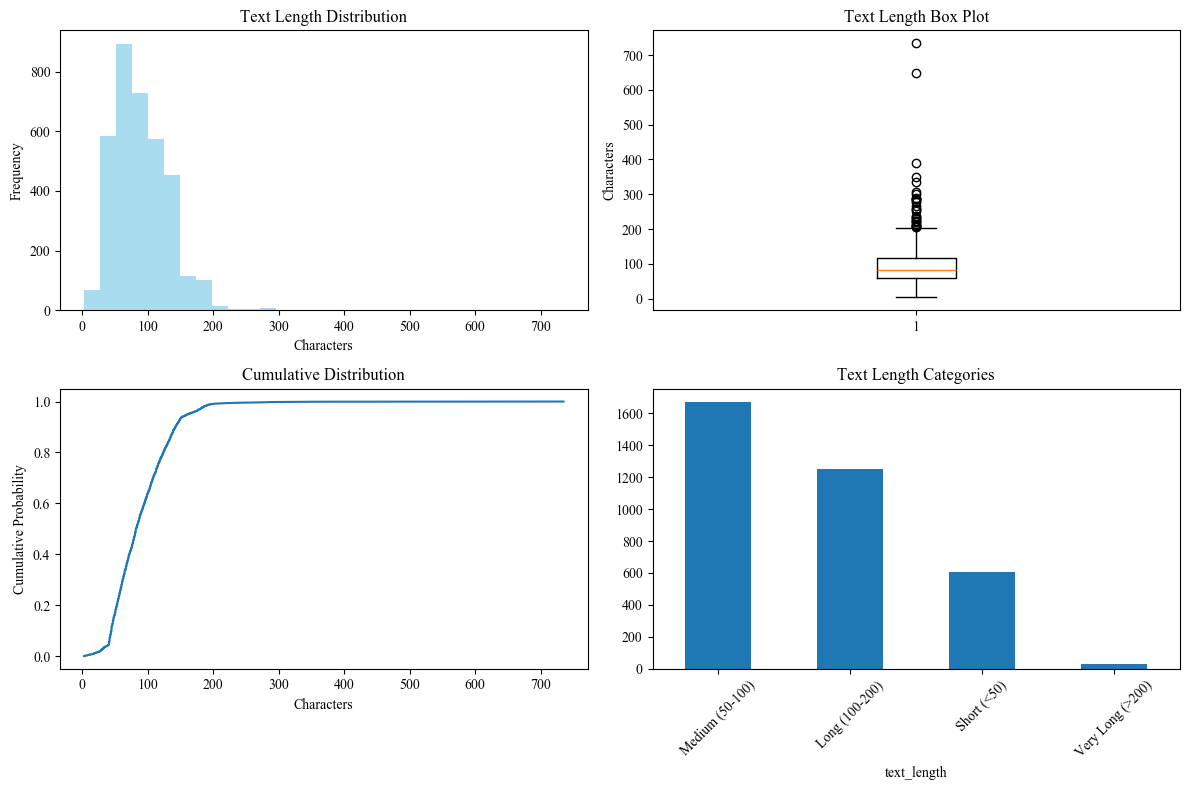

ANOMALY DETECTION
Issues found:
- Found 2 very short texts (< 5 characters)


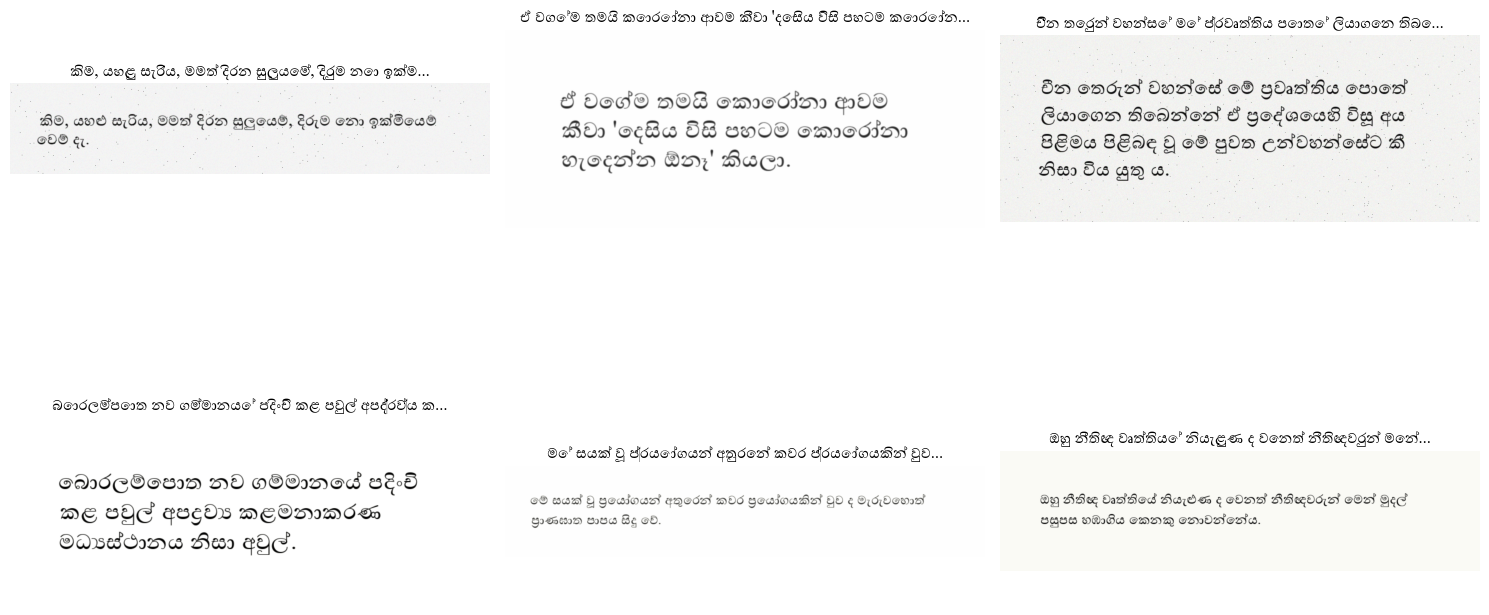

In [7]:
# Example usage
if __name__ == "__main__":
    # Initialize analyzer with your simplified dataset
    analyzer = DatasetAnalyzer('dataset.csv', 'images/')
    
    # Run analysis
    analyzer.basic_statistics()
    analyzer.text_length_distribution()
    analyzer.detect_anomalies()
    analyzer.visualize_sample_images()